In [6]:
from celmech.disturbing_function import *
from sympy import symbols, init_printing, Function,simplify,collect,cos,expand,I,re,expand_trig
init_printing()
import numpy as np
from celmech.poincare import Poincare, PoincareHamiltonian
import matplotlib
%matplotlib inline

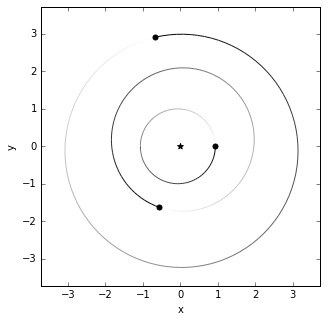

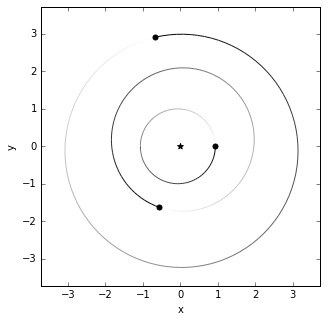

In [8]:
np.random.seed(123)
import rebound
def make_sim(pratio1,pratio2):
    mass = 1.e-5
    e0 = 0.07 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, P=1.)
    sim.add(m=mass, e=.1, P=pratio1, pomega=2*np.pi*np.random.rand())
    sim.add(m=mass, e=.04, P=pratio1*pratio2, pomega=2*np.pi*np.random.rand())
    sim.move_to_com()
    return sim     

sim=make_sim(np.sqrt(7),np.sqrt(4.3))
sim.integrator='whfast'
sim.dt=sim.particles[1].P / 25.
rebound.plotting.OrbitPlot(sim);

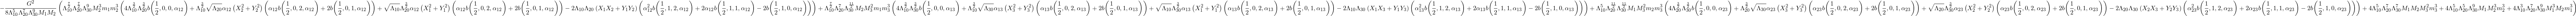

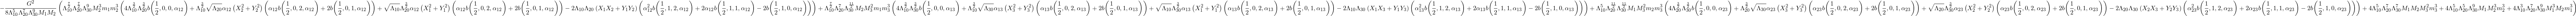

In [9]:
pvars = Poincare.from_Simulation(sim)
Hsim = PoincareHamiltonian(pvars)
Hsim.add_secular_terms(1,2,2,fixed_Lambdas=True)
Hsim.add_secular_terms(1,3,2,fixed_Lambdas=True)
Hsim.add_secular_terms(2,3,2,fixed_Lambdas=True)
Hsim.set_secular_mode()

In [10]:
tFin,Nout= 8e5,500
times= np.linspace(0,tFin,Nout)
Pecc = np.zeros((3,Nout))
Necc = np.zeros((3,Nout))

for i,t in enumerate(times):
    Pecc[0,i] = Hsim.state.particles[1].eccentricity
    Necc[0,i] = sim.particles[1].e

    Pecc[1,i] = Hsim.state.particles[2].eccentricity
    Necc[1,i] = sim.particles[2].e

    Pecc[2,i] = Hsim.state.particles[3].eccentricity
    Necc[2,i] = sim.particles[3].e


    Hsim.integrate(t)
    sim.integrate(t)

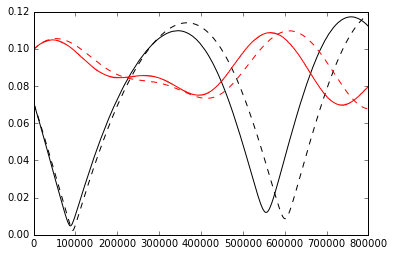

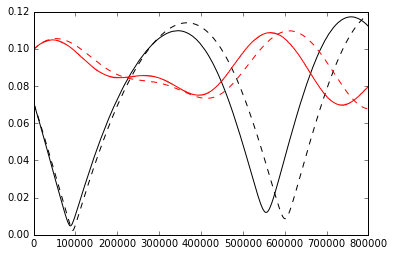

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(times,Necc[0],'k')
plt.plot(times,Pecc[0],'k--')
plt.plot(times,Necc[1],'r')
plt.plot(times,Pecc[1],'r--')